## Introduction
This is the supplementary material for a referee report on Pitt and Hill (2016).

## Reading data

In [45]:
from __future__ import division, print_function
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import random
from collections import Counter
from IPython.display import display
%matplotlib inline

In [2]:
# Reading data
biyashee_colony_cnts = pd.read_csv('data/Bishayee Colony Counts 10.27.97-3.8.01.csv', skiprows=2)
biyashee_coulter_cnts = pd.read_csv('data/Bishayee Coulter Counts.10.20.97-7.16.01.csv', skiprows=1)
other_colony_cnts = pd.read_csv('data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv', skiprows=1)
other_coulter_cnts = pd.read_csv('data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.csv', skiprows=1)
outside_coulter_cnts1 = pd.read_csv('data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.csv')
outside_coulter_cnts2 = pd.read_csv('data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.csv', skiprows=1)
outside_colony_cnts =  pd.read_csv('data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.csv', skiprows=1)

# standardizing column names for dataframes
biyashee_colony_cnts.columns = ['Isotope', 'Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
biyashee_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
other_colony_cnts.columns = ['Bates', 'Date', 'Inv', 'c1', 'c2', 'c3', 'avg']
other_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg', 'Inv']
outside_coulter_cnts1.columns = ['Experiment', 'c1', 'c2', 'c3', 'avg', 'Date']
outside_coulter_cnts2.columns = ['Date', 'c1', 'c2', 'c3', 'avg']
outside_colony_cnts.columns = ['Date', 'c1', 'c2', 'c3', 'avg']

# converting to numerics
biyashee_colony_cnts['c3'] = pd.to_numeric(biyashee_colony_cnts['c3'], errors = 'coerce')
other_colony_cnts['c3'] = pd.to_numeric(other_colony_cnts['c3'], errors = 'coerce')

# filling in experiment and date info
def fill_na(df, column):
    df[column] = df[column].fillna(method='ffill')

fill_na(outside_coulter_cnts1, 'Experiment')
fill_na(outside_coulter_cnts1, 'Date')
fill_na(outside_coulter_cnts2, 'Date')
fill_na(outside_colony_cnts, 'Date')

## Triplicate Analysis: Mean Containing Triplicate Analysis
### Checking the assumptions

We try to replicate Table 1 in the paper. Frist we apply the authors closed form equation in their appendix to calculate the probability that a triplicate drawn from an i.i.d. Poission distribution contains their own rounded mean. Then we use the simulation based approach to verify the validity of their formula.

The function `MidProb` is defined using the authors formula, and the `MidProb_Sim` is defined using simulation approach

In [3]:
def entry(j, N, lamb):
    P1 = stats.poisson.pmf(range(j, N + 1), lamb)
    P2 = stats.poisson.pmf(range(0, N + 1 - j), lamb)
    P3 = stats.poisson.pmf(range(j - int(j / 2), N + 1 - int(j / 2)), lamb)
    P4 = (j % 2) * stats.poisson.pmf(range(j - int(j / 2) - 1, N + 1 - int(j / 2) - 1), lamb)
    # Each entry P1, P2, (P3 + P4) represents the probability of a mean-containing triple with max and min fixed
    return sum(P1 * (P3 + P4) * P2)

# Closed form formula for MidProb
def MidProb(lamb):
    P_A = 0
    # Choosing N to be sufficiently large so most outcomes are covered
    N = int(stats.poisson.isf(10 ** (-9), lamb))
    for j in range(2, N + 1):
        P_A += entry(j, N, lamb)
    return P_A * 6

In [4]:
# Simulation-based approach for MidProb
def MidProb_Sim(lamb):
    N = 100000
    # Random Poisson triples generated
    samples = np.random.poisson(lamb, (N, 3))
    # Gap greater than or equal to 2
    filtered = samples[np.max(samples, axis=1) - np.min(samples, axis=1) >= 2]
    mean = np.round(np.mean(filtered, axis=1)).astype(int)
    contains_mean = np.logical_or(np.logical_or(mean == filtered[:, 0], mean == filtered[:, 1]), mean == filtered[:, 2])
    return sum(contains_mean) / N

We create a table of `MidProb` for $\lambda$ ranging from 0 to 1999, using function `MidProb`$(\lambda)$.

Running this panel may take a while, we recommand readers to refer to `TableI.csv` in the GitHub.

In [ ]:
# Create table 1 for lambda from 0 to 1999
# Warning: This may take a while!!
prob_table_list = []
for lamb in range(2000):
    prob_table_list.append(MidProb(lamb))
prob_table = np.asarray(prob_table_list)

In [6]:
# np.savetxt('Table1.csv', prob_table, fmt='%10.5f')

#### Print Table 1

In case readers want to load `prob_table` from the csv file, uncomment the following box and run.

In [6]:
prob_table = np.genfromtxt('Table1.csv')

In [7]:
print('---------------Table 1. Partial MidProb table---------------')
print(prob_table[1:26].reshape(5, 5).T)

---------------Table 1. Partial MidProb table---------------
[[ 0.26703  0.37189  0.31731  0.28051  0.25429]
 [ 0.38698  0.3593   0.30879  0.27459  0.24991]
 [ 0.40297  0.34751  0.30092  0.26905  0.24575]
 [ 0.39669  0.3366   0.29362  0.26384  0.2418 ]
 [ 0.38482  0.32655  0.28683  0.25893  0.23805]]


In [8]:
# Check that prob never exceeds 0.42
print(max(prob_table))

0.40297


In [9]:
# Check if the authors formula is valid.
print('Mid Prob (lambda = 20) produced by simulation: {0:.3f}'.format(MidProb_Sim(20)))
print('Mid Prob (lambda = 20) produced by closed form solution: {0:.3f}'.format(MidProb(20)))

Mid Prob (lambda = 20) produced by simulation: 0.258
Mid Prob (lambda = 20) produced by closed form solution: 0.259


### Replication
#### Hypothesis Testing I

In [10]:
p = 0.42

n_triplicate_containing_avg = 690
n_samples = 1343
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print('RTS data: {0:1.3e}'.format(prob))

n_triplicate_containing_avg = 109
n_samples = 572
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print('Rest of the lab: {0:1.3e}'.format(prob))

RTS data: 2.853e-12
Rest of the lab: 1.000e+00


#### Hypothesis Testing II & III

The following boxes are for the mission of replicating Table 2 in the paper.
There are two main functions in class `Testing`. `GetTestData` loads the colony count data and filters out NA values and observations that have gap smaller than `gap`. $TestStats$ calculate the test statistics in Table 2, such as `No. expected`, `Sd` and $p \ge z$.

Notice that to run the following boxes, we need `rpy2` packages installed and configured, and we also need R core and R package `poibin` installed. The code works well on a Linux machine.

In [12]:
import readline
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
import rpy2.robjects as ro

In [81]:
class Testing:
    """
    Input: 
        rawData: dataframe of the count file;
        N_mean: number of samples include its own rounded mean
        prob_table: probability table presented in table 1
    Output:
        Test statistics (all listed in table 2):
            No. expected
            Sd
            Z
            p value
    """
    def __init__(self, rawData, N_mean, prob_table, GAP=2):
        self.rawdata = rawData
        self.N_mean = N_mean
        self.gap = GAP
        self.prob_table = prob_table
        
        self.rawData, self.prob = self.GetTestData()
        self.T_Stats = self.TestStats()

    def GetTestData(self):
        raw_dataframe = self.rawdata[['c1', 'c2', 'c3']].dropna()
        print('Total Sample Size: ', raw_dataframe.shape[0])
        raw_dataframe['gap'] = raw_dataframe[['c1', 'c2', 'c3']].apply(
            lambda x: np.max(x) - np.min(x), axis=1)
        raw_dataframe = raw_dataframe[raw_dataframe.gap >= self.gap]
        print('Complete Sample Size: ', raw_dataframe.shape[0])
        
        raw_dataframe['Mean'] = np.round(raw_dataframe[['c1', 'c2', 'c3']].mean(axis=1)).astype(int)
        
        try:
            raw_dataframe['prob'] = raw_dataframe.Mean.apply(lambda x: self.prob_table[x])
        except:
            raw_dataframe['prob'] = raw_dataframe.Mean.apply(lambda x: MidProb(x))

        prob = raw_dataframe.prob.values

        return raw_dataframe, prob

    def TestStats(self):
        Mu = sum(self.prob)
        Std = np.sqrt(self.prob.dot(1 - self.prob))
        Z = (self.N_mean - 0.5 - Mu) / Std
        
        poibin = importr('poibin')
        pvalue = 1 - poibin.ppoibin(self.N_mean - 1, FloatVector(self.prob.tolist()))[0]
        print('------------------------------')
        print('NO.expected: {0}'.format(Mu))
        print('Sd: {0}'.format(Std))
        print('Z: {0}'.format(Z))
        print('p >= k: {0}'.format(pvalue))
        print('------------------------------')
        return(Mu, Std, Z, pvalue)

##### RTS

In [82]:
# Test results using complete samples
RTS = Testing(biyashee_colony_cnts, 690, prob_table_list, 2)

Total Sample Size:  1361
Complete Sample Size:  1343
------------------------------
NO.expected: 214.92360210732295
Sd: 13.281792141052023
Z: 35.731352580487446
p >= k: 3.4416913763379853e-15
------------------------------


In [83]:
# Test results using total samples
RTS = Testing(biyashee_colony_cnts, 690, prob_table_list, 0)

Total Sample Size:  1361
Complete Sample Size:  1361
------------------------------
NO.expected: 220.31368423458414
Sd: 13.418144546253146
Z: 34.96655697425994
p >= k: 0.0
------------------------------


##### Others

In [84]:
Others = Testing(other_colony_cnts, 109, prob_table_list, 2)

Total Sample Size:  597
Complete Sample Size:  578
------------------------------
NO.expected: 103.40456651970108
Sd: 9.061666440887395
Z: 0.5623064492097918
p >= k: 0.2843866673149962
------------------------------


##### Outside Lab

In [85]:
Outside = Testing(outside_colony_cnts, 3, prob_table_list, 2)

Total Sample Size:  50
Complete Sample Size:  49
------------------------------
NO.expected: 7.788269192425835
Sd: 2.5544014206605796
Z: -2.070257693114759
p >= k: 0.9892860552887166
------------------------------


### Alternative Analysis: Permutation Test
As an alternative test, we circumvent the assumption that the samples are generated from a Poisson process, by conducting permutation tests on the same Coulter and colony data sets to verify the conclusion from the earlier section. For this, we first pool together all the sample data for Coulter and colony counts respectively. We then draw random samples from the pool, where the size of the sample is equal to that of the RTS investigator. Two methods are employed.

**Method 1**: We first run a simulation of 10,000 draws. In those 10,000 draws, we count the number (and proportion) of draws containing equal or more mean-containing triplicates than those observed in RTS investigator data set.

**Method 2**: To get a more precise bound, we proceed to calculate the probability analytically using a hypergeometric distribution. In modeling the distribution, we define
* success: the event that the triplicate counts contains its rounded mean
* $N$: The total number of triplicates in the pooled samples (for Coulter and colony counts respectively)
* $K$: The total number of mean-containing triplicates
* $n$: The sample size of the RTS investigator data set
* $k$: The count of mean-containing triplicates in the RTS investigator's data set

#### Helper Functions ####

In [5]:
import warnings
warnings.filterwarnings('ignore')

# pool all samples for triplicate testing
def triplicate_pool_all_samples(dfs):
    samples = dfs[0][['c1', 'c2', 'c3']]
    for df in dfs[1:]:
        samples = samples.append(df[['c1', 'c2', 'c3']], ignore_index=True)
    return samples

# remove rows with adjacent count values 
def triplicate_remove_consecutives(df):
    '''remove triplicate rows with adjacent count values, i.e. max(triplicate count) - min(triplicate count) < 2'''
    return df[df[['c1', 'c2', 'c3']].max(axis=1) - df[['c1', 'c2', 'c3']].min(axis=1) >= 2]

def helper_contains_mean(df_row):
    '''returns true if any of c1, c2 or c3 equals the triplicate average '''
    return (df_row['mean'] == df_row['c1'] or 
            df_row['mean'] == df_row['c2'] or 
            df_row['mean'] == df_row['c3'])

# clean up data and add a new column to the data frame indicating if the triplicate contains its rounded mean
def triplicate_has_mean(df):
    '''append df with an extra column of booleans indicating if each row of triplicate contains its own mean'''
    # drop NA values and convert c1, c2, c3 to int type
    df = df.dropna()
    df[['c1', 'c2', 'c3']] = df[['c1', 'c2', 'c3']].astype(int)
    
    # calculate mean and append a new column of mean values to df
    df['mean'] = df.mean(axis=1).round(0).astype(int)

    # calculate if each row of triplicate contains its own mean and append a new boolean column to df
    df['contains_mean'] = df.apply(helper_contains_mean, axis=1)
    
    return df

#### Step 1. Pool all the samples ####

In [6]:
coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]

coulter_samples = triplicate_pool_all_samples(coulter_dfs)
colony_samples = triplicate_pool_all_samples(colony_dfs)

#### Step 2. Check for mean-containing triplicate in the pooled samples ####

In [7]:
coulter_samples_mean = triplicate_has_mean(coulter_samples)
colony_samples_mean = triplicate_has_mean(colony_samples)

#### Step 3. Permutation test functions for triplicate count test ####
We implemented 2 types of permutation tests. One performed simulations of n_sim random samplings, and the other calculated the theoretical probability of obtaining test_statisc or more of mean-containing triplicates.

In [8]:
def tri_perm_test_sampling(pooled_samples, n, n_perm, test_statistic):
    '''permutation test for triplicate mean counts'''
    x = []
    for i in range(n_perm):
        x.append(sum(random.sample(pooled_samples.tolist(), n)))
    x = np.asarray(x)
    print("Ploting permutation histogram with random {0} samplings".format(n_perm))
    plt.hist(x, bins=100)
    plt.show()
    print("maximum values in the permutation sampling: ", max(x))

    return np.count_nonzero(x >= test_statistic) / float(len(x))

def tri_perm_test_theoretical(pooled_samples, n, test_statistic):
    '''permutation test for triplicate mean counts
    pooled_samples should be a series'''
    
    # rv is the hypergeometric variable in question
    rv = stats.hypergeom(pooled_samples.size, pooled_samples.sum(), n)
    
    # Plotting a sample draw (optional)
    (lower, upper) = rv.interval(0.9999)
    x = np.arange(lower, upper)
    print ("Ploting hypergeometric pmf with n = {0}".format(n))
    plt.plot(x, rv.pmf(x), label = "hypergeometric distribution")
    plt.axvline(x = test_statistic, color = "green", label = "test statistics")
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    
    # pooled_samples.size is the total number of triplets
    # pooled_samples.sum() is the number of marked triplets
    # n is the number of sampels drawn
    return rv.sf(test_statistic - 1)

#### Step 4.a Perform the permutation test on all coulter and colony samples. ####

In [9]:
# values of n and test_statistic are obtained from PNAS paper Table 2 (pg 7)
n_coulter = 1727
n_colony = 1361
test_statistic_coulter = 177
test_statistic_colony = 708
n_sim = 10000

##### 4.a.1 Coulter Counts #####

Ploting permutation histogram with random 10000 samplings


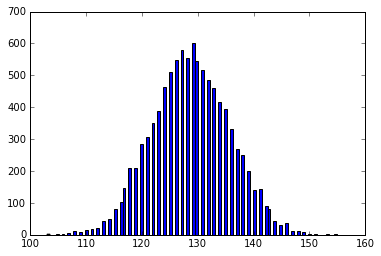

maximum values in the permutation sampling:  155


In [10]:
# permutation test by sampling on Coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(coulter_samples_mean['contains_mean'], n_coulter, n_sim, test_statistic_coulter)

Ploting hypergeometric pmf with n = 1727


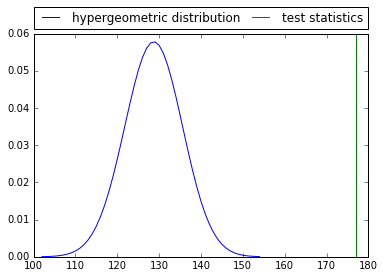

Permutation Test on Coulter Samples
Size of sameple: 1727
Test statistic: 177
Probability that sample permutation >= test statistic: 1.334e-13


In [11]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(coulter_samples_mean['contains_mean'], n_coulter, test_statistic_coulter)

# print out key information as output
print ("Permutation Test on Coulter Samples")
print ("Size of sameple: {0}".format(n_coulter))
print ("Test statistic: {0}".format(test_statistic_coulter))
print ("Probability that sample permutation >= test statistic: {0:1.3e}".format(test_result_theory))

##### 4.a.2 Colony Counts #####

Ploting permutation histogram with random 10000 samplings


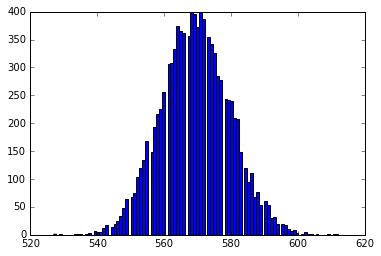

maximum values in the permutation sampling:  612


In [12]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(colony_samples_mean['contains_mean'], n_colony, n_sim,
                                              test_statistic_colony)

Ploting hypergeometric pmf with n = 1361


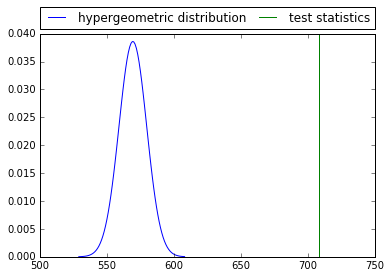

Permutation Test on Colony Samples
Size of sameple: 1361
Test statistic: 708
Probability that sampled permutation >= test statistic: 2.404e-43


In [13]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(colony_samples_mean['contains_mean'], n_colony, test_statistic_colony)

# print out key information as output
print ("Permutation Test on Colony Samples")
print ("Size of sameple: {0}".format(n_colony))
print ("Test statistic: {0}".format(test_statistic_colony))
print ("Probability that sampled permutation >= test statistic: {0:1.3e}".format(test_result_theory))

#### Step 4.b Perform the permutation test on all coulter and colony samples MINUS triplicates with adjacent counts. ####

In [14]:
n_coulter = 1726
n_colony = 1343
test_statistic_coulter = 176
test_statistic_colony = 690
n_sim = 10000

coulter_samples_mean = triplicate_remove_consecutives(coulter_samples_mean)
colony_samples_mean = triplicate_remove_consecutives(colony_samples_mean)

##### 4.b.1 Coulter Counts #####

Ploting permutation histogram with random 10000 samplings


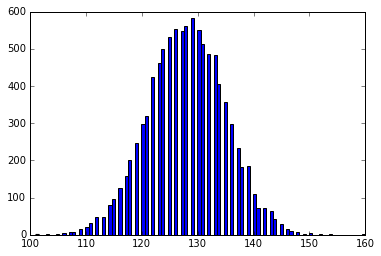

maximum values in the permutation sampling:  160


In [15]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(coulter_samples_mean['contains_mean'], n_coulter, n_sim, test_statistic_coulter)

Ploting hypergeometric pmf with n = 1726


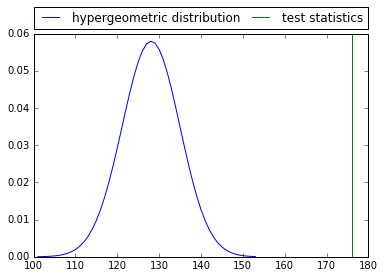

Permutation Test on Coulter Samples
Size of sameple:  1726
Test statistic:  176
Probability that sample permutation >= test statistic: 1.840e-13


In [24]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(coulter_samples_mean['contains_mean'], n_coulter, test_statistic_coulter)

# print out key information as output
print ("Permutation Test on Coulter Samples")
print ("Size of sameple: ", n_coulter)
print ("Test statistic: ", test_statistic_coulter)
print ("Probability that sample permutation >= test statistic: {0:1.3e}".format(test_result_theory))

##### 4.b.2 Colony Counts #####

Ploting permutation histogram with random 10000 samplings


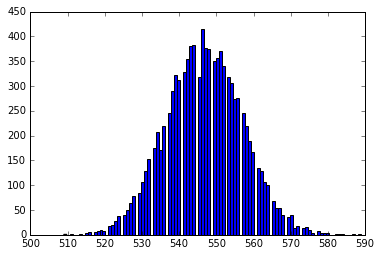

maximum values in the permutation sampling:  589


In [16]:
# permutation test by sampling on coulter samples (and plot the distribution histogram)
test_result_sampling = tri_perm_test_sampling(colony_samples_mean['contains_mean'], n_colony, n_sim,
                                              test_statistic_colony)

Ploting hypergeometric pmf with n = 1343


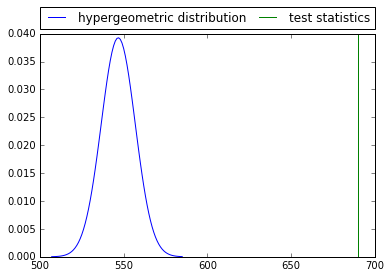

Permutation Test on Colony Samples
Size of sameple:  1343
Test statistic:  690
Probability that sampled permutation >= test statistic: 2.964e-48


In [17]:
# pmf of hypergeometric distribution for coulter samples
test_result_theory = tri_perm_test_theoretical(colony_samples_mean['contains_mean'], n_colony, test_statistic_colony)

# print out key information as output
print ("Permutation Test on Colony Samples")
print ("Size of sameple: ", n_colony)
print ("Test statistic: ", test_statistic_colony)
print ("Probability that sampled permutation >= test statistic: {0:1.3e}".format(test_result_theory))

## Triplicate Analysis: Mid-Ratio Analysis

### Expeceted percent of samples with mid-ratio [.40, .60]
For all integer values of $\lambda$ from 1 to 2000, we simmulate 10,000 poisson triplicates and calculate the mid-ratio for each triplicate. Here the mid-ratio is defined as the ratio of the difference between the median and the smallest value of the triplicate to the difference between the largest and smallest value of the triplicate. 
We then calculate the percentage of mid-ratios that fall in the interval [0.4, 0.6]. Our results match with those reported in the paper --- the percent of mid ratio test in the interval [0.4, 0.6] never exceeds 0.26.

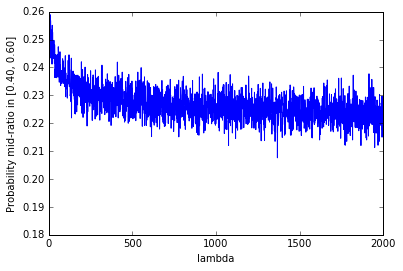

In [18]:
# simulate Poisson
def mid_ratio(x):
    # x = n x 3 matrix of poisson variables
    return (np.median(x, 1) - np.min(x, 1)) / (np.max(x, 1) - np.min(x, 1))

def mid_ratio_40_60(x):
    # x = n-vector of mid-ratios
    # returns the percent of samples that have mid-ratio in [.40,.60]
    return np.count_nonzero((x >= .4) & (x <= .6)) / float(len(x))

def midratio_poisson_tv(lamb, n_sim):
    sim_poisson = np.random.poisson(lamb, size=(n_sim, 3))
    mid_ratios = mid_ratio(sim_poisson)
    return mid_ratio_40_60(mid_ratios)

v_midratio_poisson_tv = np.vectorize(midratio_poisson_tv)
# Range of mu we are plotting
x = np.arange(1, 2000)
plt.plot(x, v_midratio_poisson_tv(x, 10000))
plt.xlabel('lambda')
plt.ylabel('Probability mid-ratio in [0.40, 0.60]')

Pitt and Hill report that the RTS investigator has a high number of triplicates with a mid-ratio value in the interval [0.4, 0.6], but they do not actually report how unlikely such a result is.

From our investigation, we find that 824 of 1362 colony counts and 523 of 1729 coulter counts produced by the RTS investigator have a mid-ratio value in the interval [0.4, 0.6]. If, as Pitt and Hill suggest, we model the probability of mid-ratio in [0.4, 0.6] as a Bernouli process and conservatively assign the probability of success, p = 0.26, then the probability of observing 824 or more successes in 1362 colony count trials is 1.11e-16. The probability of observing 523 or more successes in 1729 coulter count triplicates is 3.26e-5. Both corroborate the idea that it is very unlikely that a Poisson process produced this many triplicates with midratios in the interval [0.4, 0.6]. 

In [19]:
rts_mid_ratios_colony = mid_ratio(biyashee_colony_cnts[['c1', 'c2', 'c3']].values)
rts_mid_ratio_count_colony = mid_ratio_40_60(rts_mid_ratios_colony) * len(rts_mid_ratios_colony)
print('{0} of {1} RTS colony triplicates have mid-ratios in interval [0.4, 0.6]'.format(
        int(rts_mid_ratio_count_colony), len(rts_mid_ratios_colony)))

rts_mid_ratios_coulter = mid_ratio(biyashee_coulter_cnts[['c1', 'c2', 'c3']].values)
rts_mid_ratio_count_coulter = mid_ratio_40_60(rts_mid_ratios_coulter) * len(rts_mid_ratios_coulter)
print('{0} of {1} RTS Coulter triplicates have mid-ratios in interval [0.4, 0.6]'.format(
        int(rts_mid_ratio_count_coulter), len(rts_mid_ratios_coulter)))

prob_rts_mid_ratio_colony = stats.binom.sf(rts_mid_ratio_count_colony, len(rts_mid_ratios_colony), .26)
prob_rts_mid_ratio_coulter = stats.binom.sf(rts_mid_ratio_count_coulter, len(rts_mid_ratios_coulter), .26)

print('p of seeing at least {0} of {1} triplicates with mid-ratios in interval [0.4, 0.6] = {2:.4f}'.format(
        int(rts_mid_ratio_count_colony), len(rts_mid_ratios_colony), prob_rts_mid_ratio_colony))
print('p of seeing at least {0} of {1} triplicates with mid-ratios in interval [0.4, 0.6] = {2:.4f}'.format(
        int(rts_mid_ratio_count_coulter), len(rts_mid_ratios_coulter), prob_rts_mid_ratio_coulter))

824 of 1362 RTS colony triplicates have mid-ratios in interval [0.4, 0.6]
523 of 1729 RTS Coulter triplicates have mid-ratios in interval [0.4, 0.6]
p of seeing at least 824 of 1362 triplicates with mid-ratios in interval [0.4, 0.6] = 0.0000
p of seeing at least 523 of 1729 triplicates with mid-ratios in interval [0.4, 0.6] = 0.0000


## Terminal digits analysis
### Testing the assumptions
#### Is the terminal digit of a Poisson variable uniform?
For each `mu`, we compute its total variation distance of the terminal digit distribution again the uniform distribution. We generate a vector containing 99.9% its probability mass. We reshape it into an array with 10 columns, allowing us to add the probability mass by terminal digits.

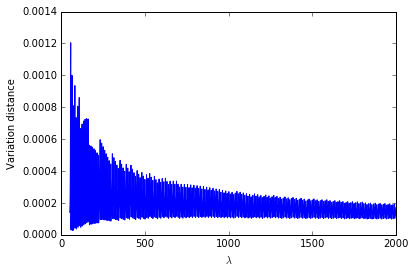

In [20]:
def termd_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 10) * 10
    prob = stats.poisson.pmf(np.arange(num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 10))
    return np.linalg.norm(prob.sum(axis=0) - np.ones(10) / 10, 1)

v_termd_poisson_tv = np.vectorize(termd_poisson_tv)
# Range of mu we are plotting
x = np.arange(50, 2000)
plt.plot(x, v_termd_poisson_tv(x))
plt.xlabel(r'$\lambda$')
plt.ylabel('Variation distance')

As observed above, the total variation distance is moderately close to 0. (The lack of convergence to 0 is due to the a truncated Poisson distribution is used in computation.) This validates the assumption.

### Replication

In [46]:
def termd_count(df):
    '''counts the terminal digit in dataframe df. df must have c1, c2, c3'''
    c = Counter(df[['c1','c2','c3']].values.flatten()%10)
    return [c[i] for i in range(10)]

# corresponds to table 3 in Pitt and Hill
table3 = pd.DataFrame([termd_count(biyashee_colony_cnts),
                       termd_count(biyashee_coulter_cnts),
                       termd_count(other_colony_cnts),
                       termd_count(other_coulter_cnts),
                       termd_count(outside_coulter_cnts1),
                       termd_count(outside_coulter_cnts2),
                       termd_count(outside_colony_cnts)],
                      columns = range(10))
table3['index'] = pd.Series(['biyashee_colony_cnts', 'biyashee_coulter_cnts',
                             'other_colony_cnts', 'other_coulter_cnts',
                             'outside_coulter_cnts1', 'outside_coulter_cnts2',
                             'outside_colony_cnts'],
                            index=table3.index)
table3.set_index('index', inplace=True)
table3.index.name = None
table3['total'] = table3.sum(axis=1)
table3['chi-square'] = 0
for i in range(10):
    table3['chi-square'] += (table3[i] - table3['total'] / 10) ** 2 / (table3['total'] / 10)
table3['p'] = stats.chisqprob(table3['chi-square'], 9)
display(table3)

,0,1,2,3,4,5,6,7,8,9,total,chi-square,p
biyashee_colony_cnts,564,324,463,313,290,478,336,408,383,526,4085,200.725826,2.333780e-38
biyashee_coulter_cnts,475,613,736,416,335,732,363,425,372,718,5185,466.874638,7.062273e-95
other_colony_cnts,191,181,195,179,184,175,178,185,185,181,1834,1.790622,9.943625e-01
other_coulter_cnts,261,311,295,259,318,290,298,283,331,296,2942,15.994562,6.699524e-02
outside_coulter_cnts1,28,34,29,25,27,36,44,33,26,33,315,9.476190,3.945273e-01
outside_coulter_cnts2,34,38,45,35,32,42,31,35,35,33,360,4.944444,8.391240e-01
outside_colony_cnts,21,9,15,16,19,19,9,19,11,12,150,12.133333,2.058966e-01


Although the `total` column in the paper does not add up correctly, fixing it did not change the p-values much.

### Alternative analysis: Permutation test

Step 1. Pool all the samples together.

In [47]:
# pool all samples:
def pool_all_samples(dfs):
    samples = np.array([])
    for df in dfs:
        samples = np.append(samples,df[['c1', 'c2', 'c3']].values.flatten())
    return samples

coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]


coulter_samples = pool_all_samples(coulter_dfs)
colony_samples = pool_all_samples(colony_dfs)

Step 2. Permutation test for how far sample is from uniform

In [23]:
def chi_squared_term_digit(samples):
    chi_squared = 0
    termd = samples % 10
    # N = all samples that are not NaNs
    N = np.count_nonzero(~np.isnan(samples))
    for i in range(10):
        ni = np.count_nonzero(termd == i) 
        chi_squared += (ni - N / 10.) ** 2 / (N / 10)
    return chi_squared
        

def chi_squared_perm_test(pooled_samples, n, n_perm, test_statistic, plot=True):
    '''
    pooled_samples = all samples 
    n = number of samples in group of interest
    test_statistic = value of observed test statistic to plot against
    n_iter = number of iterations
    '''
    test_statistics = np.array([])
    for i in range(n_perm):
        # take 1st n samples
        samples = pooled_samples[np.random.permutation(len(pooled_samples))[0:n]]  #array(i[0:n])
        # compute test statistic on these samples
        test_statistics = np.append(test_statistics, chi_squared_term_digit(samples))

    # Plotting a sample draw (optional)
    if plot:
        plt.hist(test_statistics, bins=50)
        plt.show()
    
    return np.count_nonzero(test_statistics > test_statistic) / float(len(test_statistics))

Step 3a. Perform the permutation test on coulter samples.

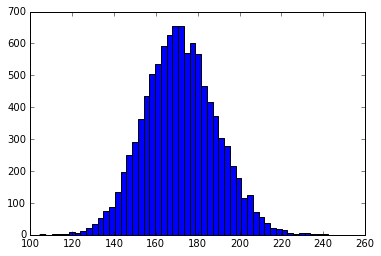

Permutation Test on Coulter Samples
Size of sameple: 5187
Test statistic: 466.87463838
Probability that sample permutation >= test statistic: 0.000e+00


In [24]:
test_samples = pool_all_samples([biyashee_coulter_cnts])
n = len(test_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
test_result = chi_squared_perm_test(coulter_samples, n, n_perm, test_statistic)

print("Permutation Test on Coulter Samples")
print("Size of sameple: {0}".format(n))
print("Test statistic: {0}".format(test_statistic))
print("Probability that sample permutation >= test statistic: {0:1.3e}".format(test_result))

Step 3b. Perform the permutation test on colony samples.

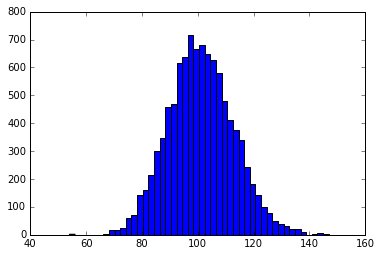

Permutation Test on Coulter Samples
Size of sameple: 4086
Test statistic: 200.725826193
Probability that sample permutation >= test statistic: 0.000e+00


In [25]:
test_samples = pool_all_samples([biyashee_colony_cnts])
n = len(test_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
test_result = chi_squared_perm_test(colony_samples, n, n_perm, test_statistic)

print("Permutation Test on Coulter Samples")
print("Size of sameple: {0}".format(n))
print("Test statistic: {0}".format(test_statistic))
print("Probability that sample permutation >= test statistic: {0:1.3e}".format(test_result))

## Equal Digit Analysis
### Assumption check

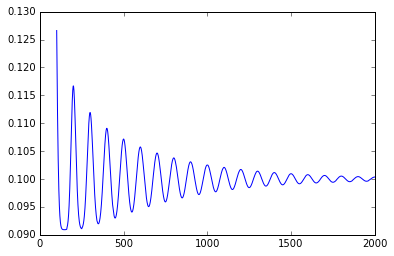

In [26]:
def term2d_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 100) * 100
    prob = stats.poisson.pmf(np.arange(100, num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 100))
    return np.sum(prob[:, 0:100:11])

v_term2d_poisson_tv = np.vectorize(term2d_poisson_tv)
# Range of mu we are plotting
x = np.arange(100, 2000)
plt.plot(x, v_term2d_poisson_tv(x))

Since a lot of the counts by RTS are around 100, the assumption of 10% is not very valid in this regime. This is porticularly troublesome when the true parameter $\lambda$ is smaller than or comparable to 100. It is significantly more likely to observe 100 than 111, upsetting the uniform distribution assumption. Subject to imprecision of model specification, it does not seem that unlikely that RTS has a ~12% matching last two digits.

# Testing our code:
The following is a collection of unit tests we ran on the code to confirm that our functions were behaving as expected. The tests are not exhaustive, but confirm that are methods are generally working as expected.

In [48]:
'''mean triplicate tests '''
test_df = pd.DataFrame([[2,2,2],
                        [1,2,3],
                        [1,6,5]], columns = ['c1','c2','c3'])

assert triplicate_remove_consecutives(test_df).equals(test_df.drop(0))
assert triplicate_has_mean(test_df)['contains_mean'].equals(pd.Series([True, True, False]))

'''mid-ratio tests'''
x = np.array([[0,1,2],[0,1,2]])
assert np.array_equal(mid_ratio(x), [0.5,0.5])

# test all in interval = 1
x = np.ones(10)*.5
assert mid_ratio_40_60(x) == 1

# test all not in interval = 0
x = np.ones(10)*.0
assert mid_ratio_40_60(x) == 0

#test counts all 0.4 - 0.6 (inclusive)
x = np.array([0.1,0.4,0.5,0.6,1.])
assert mid_ratio_40_60(x) == 0.6


'''term digit test'''
#24 ones and nothing else
test_df = pd.DataFrame(np.ones((8,3)), columns = ['c1','c2','c3'])
assert termd_count(test_df) == [0,24,0,0,0,0,0,0,0,0]

#24 zeros and nothing else
test_df = pd.DataFrame(np.zeros((8,3)), columns = ['c1','c2','c3'])
assert termd_count(test_df) == [24,0,0,0,0,0,0,0,0,0]

#small test df with a np.nan
test_df = pd.DataFrame([[2,2,2],
                        [1,2,3],
                        [0,np.nan,5]], columns = ['c1','c2','c3'])
assert termd_count(test_df) == [1,1,4,1,0,1,0,0,0,0]

'''chi_squared_term_digit(samples) test'''
#if perfectly uniform
samples = np.array([1,2,3,4,5,6,7,8,9,10])
assert chi_squared_term_digit(samples) == 0

#if all ones
samples = np.ones(10)
assert chi_squared_term_digit(samples) == 90.

'''chi_squared_perm_test(pooled_samples, n, n_perm, test_statistic)'''
pooled_samples = np.ones(100)
n = 10
n_perm=100
# test statistic for random samples should always be less than 100
test_statistic = 100
assert chi_squared_perm_test(pooled_samples, n, n_perm, test_statistic, False) == 0.

# test statistic for random samples should always be greater than 0
test_statistic = 0
assert chi_squared_perm_test(pooled_samples, n, n_perm, test_statistic, False) == 1.